<div style="text-align: center;">
  <h1 style="color: darkorange; font-family: Arial, sans-serif; margin-top: 5px;">Train a Convolutional Neural Network (CNN)</h1>
  <p style="font-weight: bold;">Le Guillouzic Maël et Nathan Rouillé</p>
</div>

<hr style="border: 1px solid lightgray; margin-top: 20px; margin-bottom: 20px;">

## 

In this Lab session we will learn how to train a CNN from scratch for classifying MNIST digits.

In [2]:
# import necessary libraries
import torch
import torchvision
from torchvision import transforms as T
import torch.nn.functional as F

import torch.nn as nn

<h2 style="color:#FF8C00; font-family:Arial, sans-serif;">
  Define LeNet
</h2>

![network architecture](https://www.researchgate.net/profile/Lucijano-Berus/publication/329891470/figure/fig1/AS:707347647307776@1545656229128/Architecture-of-LeNet-5-a-Convolutional-Neural-Network-for-digits-digits-recognition-An.ppm)

Here we are going to define our first CNN which is **LeNet** in this case. This architecture has been introduced and is detailed in [this article](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf). To construct a LeNet we will be using some convolutional layers followed by some fully-connected layers. The convolutional layers can be simply defined using `torch.nn.Conv2d` module of `torch.nn` package. Details can be found [here](https://pytorch.org/docs/stable/nn.html#conv2d). Moreover, we will use pooling operation to reduce the size of convolutional feature maps. For this case we are going to use `torch.nn.functional.max_pool2d`. Details about maxpooling can be found [here](https://pytorch.org/docs/stable/nn.html#max-pool2d)

Differently from our previous Lab, we will use a Rectified Linear Units (ReLU) as activation function with the help of `torch.nn.functional.relu`, replacing `torch.nn.Sigmoid`. Details about ReLU can be found [here](https://pytorch.org/docs/stable/nn.html#id26).

In [3]:
class LeNet(torch.nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()

    # input channel = 1, output channels = 6, kernel size = 5
    # input image size = (28,28), image output size = (24,24)
    self.conv1 = nn.Conv2d(1, 6, kernel_size=5)

    # input channel = 6, output channels = 16, kernel size = 5
    # input image size = (14,14), output image size = (10,10)
    self.conv2 = nn.Conv2d(6,16,kernel_size=5)

    # input dim = (16x5x5) ( H x W x C), output dim = 120
    self.fc1 = nn.Linear(16*4*4,120)
    
    # input dim = 120, output dim = 84
    self.fc2 = nn.Linear(120,84)

    # input dim = 84, output dim = 10
    self.fc3 = nn.Linear(84,10)

  def forward(self, x):

    x = F.relu(self.conv1(x))
    # Max Pooling with kernel size = 2
    # output size = (14,14)
    x = F.max_pool2d(x, kernel_size=2, stride=2, padding=0) # attention au debut je l'avais instancié dans l'init mais on ne peut pas le faire avec cette fonction. 
    # Si on veut init il faut utiliser MaxPool2d

    x = F.relu(self.conv2(x))
    # Max Pooling with kernel size = 2
    # output size = (5,5)
    x = F.max_pool2d(x, kernel_size=2, stride=2, padding=0)

    # flatten the feature maps into a long vector
    x = x.view(x.shape[0], -1)

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

<h2 style="color:#FF8C00; font-family:Arial, sans-serif;">
  Define cost function
</h2>

In [4]:
def get_cost_function():
  cost_function = nn.CrossEntropyLoss()
  return cost_function

<h2 style="color:#FF8C00; font-family:Arial, sans-serif;">
  Define the optimizer
</h2>

We will use SGD with learning rate-lr, weight_decay=wd and  momentum=momentum

In [5]:
def get_optimizer(net, lr, wd, momentum):
  optimizer =  torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd, momentum=momentum)
  return optimizer

<h2 style="color:#FF8C00; font-family:Arial, sans-serif;">
  Train and test functions
</h2>

In [6]:
def test(net, data_loader, cost_function, device='mps'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  net.eval() # Strictly needed if network contains layers which has different behaviours between train and test
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      # Load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)

      # Forward pass
      outputs = net(inputs)

      # Apply the loss
      loss = cost_function(outputs, targets)

      # Better print something
      samples+=inputs.shape[0]
      cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
      _, predicted = outputs.max(1)
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100


def train(net,data_loader,optimizer,cost_function, device='mps'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.


  net.train() # Strictly needed if network contains layers which has different behaviours between train and test
  for batch_idx, (inputs, targets) in enumerate(data_loader):
    # Load data into GPU
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Forward pass
    outputs = net(inputs)

    # Apply the loss
    loss = cost_function(outputs,targets)

    # Reset the optimizer

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()

    optimizer.zero_grad()

    # Better print something, no?
    samples+=inputs.shape[0]
    cumulative_loss += loss.item()
    _, predicted = outputs.max(1)
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100

<h2 style="color:#FF8C00; font-family:Arial, sans-serif;">
  Define the function that fetches a data loader that is then used during iterative training.
</h2>

We will learn a new thing in this function as how to Normalize the inputs given to the network.

***Why Normalization is needed***?

To have nice and stable training of the network it is recommended to normalize the network inputs between \[-1, 1\].

***How it can be done***?

This can be simply done using `torchvision.transforms.Normalize()` transform. Details can be found [here](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize).

In [7]:
def get_data(batch_size, test_batch_size=256):

  # Prepare data transformations and then combine them sequentially
  transform = list()
  transform.append(T.ToTensor())                            # converts Numpy to Pytorch Tensor
  transform.append(T.Normalize(mean=[0.5], std=[0.5]))      # Normalizes the Tensors between [-1, 1]
  transform = T.Compose(transform)                          # Composes the above transformations into one.

  # Load data
  full_training_data = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)
  test_data = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)


  # Create train and validation splits
  num_samples = len(full_training_data)
  training_samples = int(num_samples*0.5+1)
  validation_samples = num_samples - training_samples

  training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

  # Initialize dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

<h2 style="color:#FF8C00; font-family:Arial, sans-serif;">
  Wrapping everything up
</h2>

Finally, we need a main function which initializes everything + the needed hyperparameters and loops over multiple epochs (printing the results).

In [8]:
'''
Input arguments
  batch_size: Size of a mini-batch
  device: GPU where you want to train your network
  weight_decay: Weight decay co-efficient for regularization of weights
  momentum: Momentum for SGD optimizer
  epochs: Number of epochs for training the network
'''

def main(batch_size=512,
         device=('cuda:0' if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else 'cpu'),
         learning_rate=0.01,
         weight_decay=0.000001,
         momentum=0.9,
         epochs=50):
  
  print('Using device: {}'.format(device))

  train_loader, val_loader, test_loader = get_data(batch_size)

  net = LeNet()
  net = net.to(device)
  print('Network architecture:')
  print(net)
  print('-----------------------------------------------------')

  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

  cost_function = get_cost_function()
  
  # je veux stocker les loss et accuracy pour chaque epoch pour plot
  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')
  
  return net, test_loader, device, train_losses, val_losses, train_accuracies, val_accuracies

Lets train!

In [9]:
net, test_loader, device, train_losses, val_losses, train_accuracies, val_accuracies = main()

Using device: mps
Network architecture:
LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
-----------------------------------------------------
Before training:
	 Training loss 0.00453, Training accuracy 10.49
	 Validation loss 0.00907, Validation accuracy 10.31
	 Test loss 0.00922, Test accuracy 10.11
-----------------------------------------------------
Epoch: 1
	 Training loss 0.00450, Training accuracy 15.24
	 Validation loss 0.00887, Validation accuracy 14.29
-----------------------------------------------------
Epoch: 2
	 Training loss 0.00334, Training accuracy 46.05
	 Validation loss 0.00265, Validation accuracy 77.62
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00092, Training accuracy

**Question :**
Check which MNIST digit is most frequently confused with which other digit (e.g. plot a confusion matrix). Can you explain why?

**Réponse :** Il y a assez peu d'erreurs, les quelques unes remarquables sont peut etre :
- les 9 qui sont en réalité des 4
- les 5 qui sont en réalité des 9

Cela est surement du a une forme similaire difficile à dissocier et accentué par le fait que les chiffres sont manuscrits et donc parfois impossible à discerner correctement.

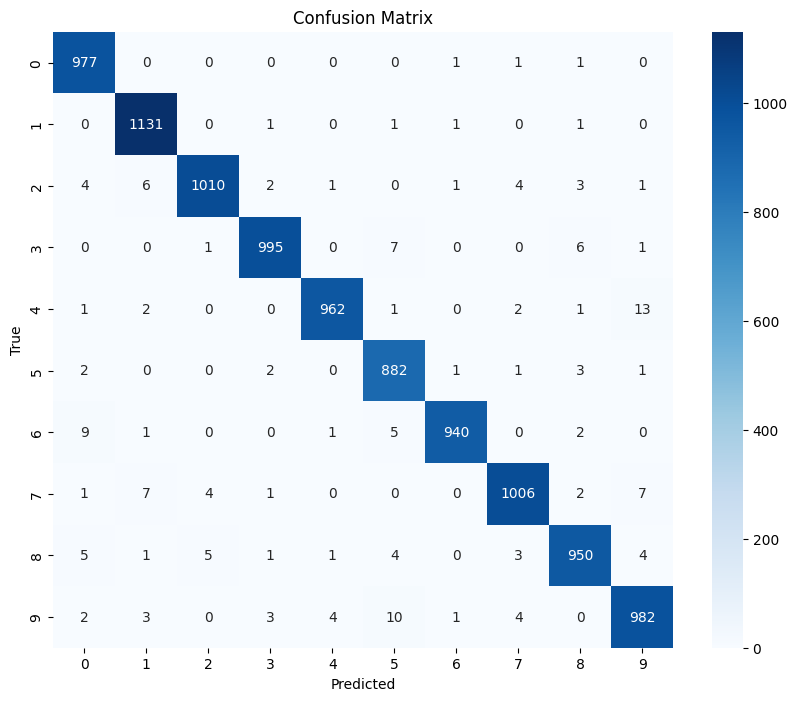

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(net, test_loader, device):
    net.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = net(data)
            pred = output.argmax(dim=1, keepdim=True).squeeze()
            
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    cm = confusion_matrix(all_targets, all_preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(10), yticklabels=range(10))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()    
    return cm

confusion_matrix_result = plot_confusion_matrix(net, test_loader, device)

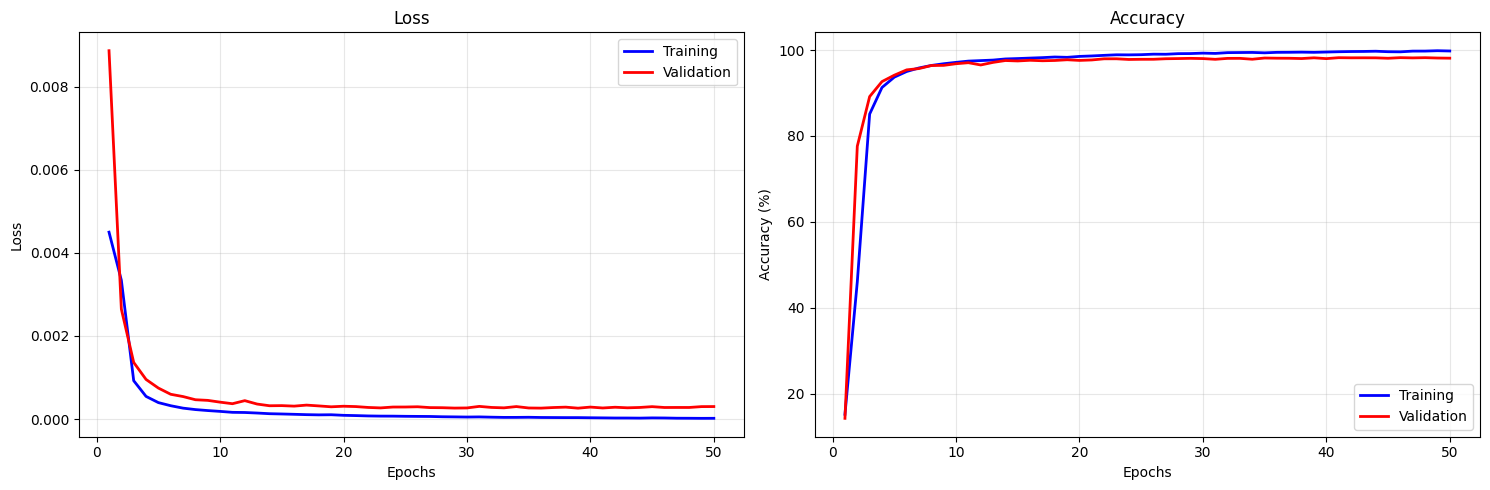

Final Training Accuracy: 99.77%
Final Validation Accuracy: 98.10%
Gap: 1.67%


In [11]:
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # loss
    ax1.plot(epochs, train_losses, 'b-', label='Training', linewidth=2)
    ax1.plot(epochs, val_losses, 'r-', label='Validation', linewidth=2)
    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Graphique des accuracies
    ax2.plot(epochs, train_accuracies, 'b-', label='Training', linewidth=2)
    ax2.plot(epochs, val_accuracies, 'r-', label='Validation', linewidth=2)
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Final Training Accuracy: {train_accuracies[-1]:.2f}%")
    print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")
    print(f"Gap: {train_accuracies[-1] - val_accuracies[-1]:.2f}%")
    
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)

The LeNet5 architecture can also be implemented using the sequential API ([see documentation](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)). Reimplement it with this API.

<h2 style="color:#FF8C00; font-family:Arial, sans-serif;">
  Experiments
</h2>

* Implement adaptive early stopping: if the validation loss did not decrease for K consecutive epochs, stop training.
* Change dataset in order to evaluate the LeNet5 network on cifar10 dataset. You can have a look at the pytorch documentation to easily access the cifar10 dataset.
* Try to improve performance with:
   *   data-augmentation
   *   dropout
* Implement the resnet18 architecture using the Resnet18 class from pytorch.

<h2 style="color:#FF8C00; font-family:Arial, sans-serif;">
  Early stopping 
</h2>

Pour implémenter l'early stopping on va le faire avec une classe qui dispose de 2 fonctions : 
- Une pour initialiser
- Une qui sera appellée a chaque epoch et evalue le critère de early stopping

In [12]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
        
    def __call__(self, val_loss, model):
        """
        On appelle cette fonction après chaque époch
        elle retourne True si l'entraînement doit s'arrêter, False sinon.
        """
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            
        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
                print(f'Early stopping. On restore les meilleurs poids de l\'epoch {self.counter}')
            return True
        return False
    
    def save_checkpoint(self, model):
        if self.restore_best_weights:
            self.best_weights = model.state_dict().copy()

On copie colle la fonction main en la modifiant un petit peu, pour y intégrer notre nouvelle classe d'Early stopping

In [13]:
def main(batch_size=128,
         device=('cuda:0' if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else 'cpu'),
         learning_rate=0.01,
         weight_decay=0.000001,
         momentum=0.9,
         epochs=50,
         early_stopping_patience=7):
  
  print('Device: {}'.format(device))

  train_loader, val_loader, test_loader = get_data(batch_size)
  net = LeNet().to(device)
  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)
  cost_function = get_cost_function()

  early_stopping = EarlyStopping(patience=early_stopping_patience, restore_best_weights=True)

  # listes pour stocker les métriques
  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function, device)
  val_loss, val_accuracy = test(net, val_loader, cost_function, device)
  test_loss, test_accuracy = test(net, test_loader, cost_function, device)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function, device)
    val_loss, val_accuracy = test(net, val_loader, cost_function, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')
    
    if early_stopping(val_loss, net):
        print(f'Early stopping at epoch {e+1}!')
        break

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function, device)
  val_loss, val_accuracy = test(net, val_loader, cost_function, device)
  test_loss, test_accuracy = test(net, test_loader, cost_function, device)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')
  
  # Tracer les courbes
  plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)
  
  return net, test_loader, device, train_losses, val_losses, train_accuracies, val_accuracies

Device: mps
Before training:
	 Training loss 0.01806, Training accuracy 9.63
	 Validation loss 0.00907, Validation accuracy 9.32
	 Test loss 0.00922, Test accuracy 9.54
-----------------------------------------------------
Epoch: 1
	 Training loss 0.01001, Training accuracy 59.70
	 Validation loss 0.00084, Validation accuracy 93.48
-----------------------------------------------------
Epoch: 2
	 Training loss 0.00127, Training accuracy 95.00
	 Validation loss 0.00051, Validation accuracy 96.04
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00078, Training accuracy 96.84
	 Validation loss 0.00038, Validation accuracy 97.13
-----------------------------------------------------
Epoch: 4
	 Training loss 0.00061, Training accuracy 97.56
	 Validation loss 0.00030, Validation accuracy 97.67
-----------------------------------------------------
Epoch: 5
	 Training loss 0.00048, Training accuracy 98.06
	 Validation loss 0.00030, Validation accuracy 97.62
------

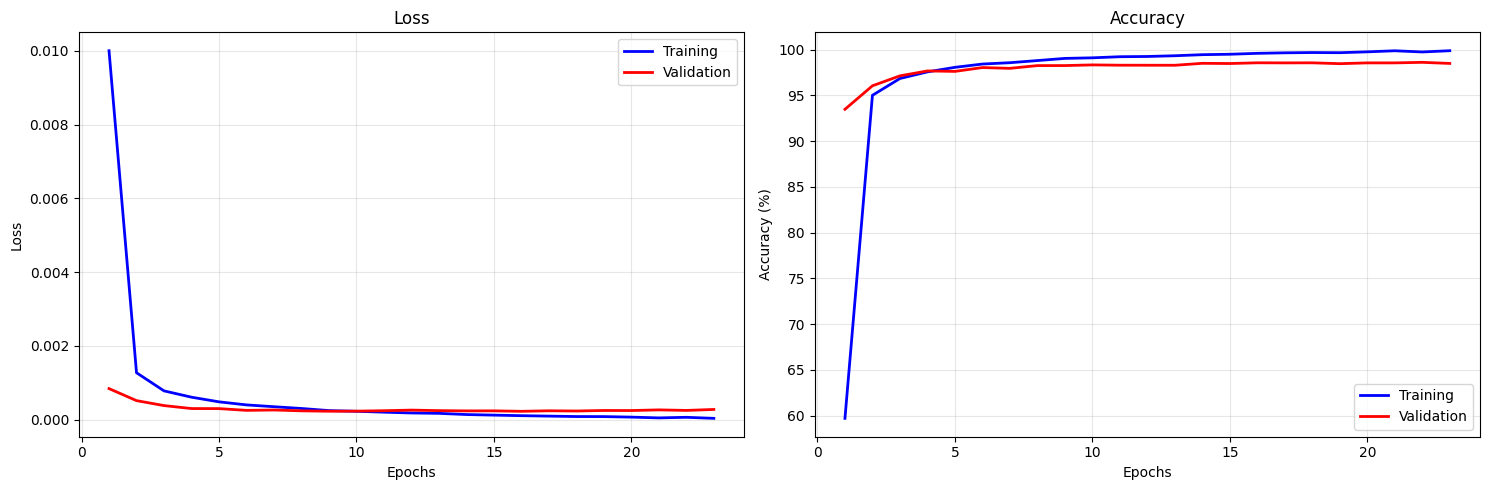

Final Training Accuracy: 99.88%
Final Validation Accuracy: 98.49%
Gap: 1.39%


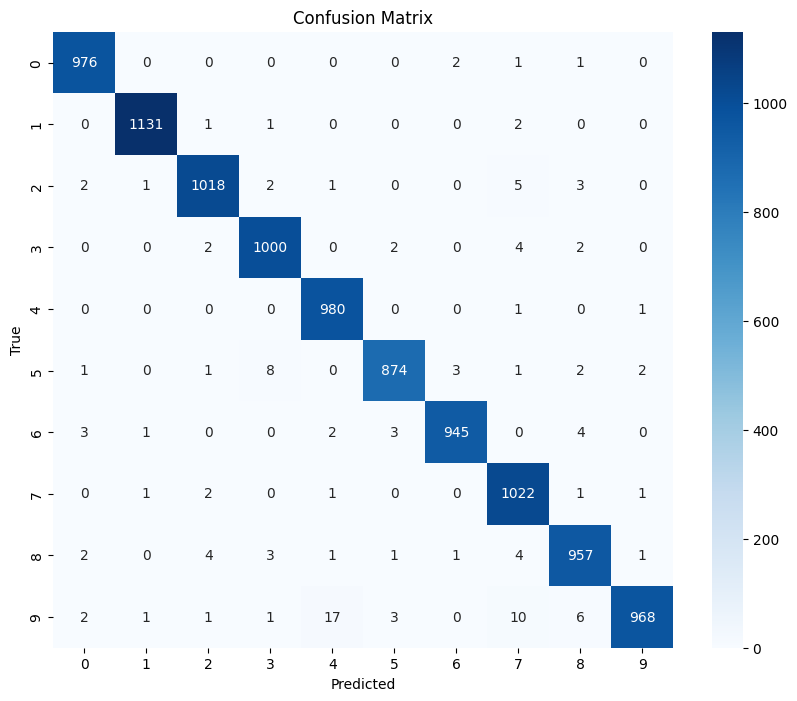

In [14]:
# on entraine avec early stopping (patience = 7 époch)
net, test_loader, device, train_losses, val_losses, train_accuracies, val_accuracies = main(
    epochs=100,
    early_stopping_patience=7  # arrêt si pas d'amélioration pendant 7 époques
)
confusion_matrix_result = plot_confusion_matrix(net, test_loader, device)

Le résultat est bien meilleur ! 

<h2 style="color:#FF8C00; font-family:Arial, sans-serif;">
  CIFAR10
</h2>

On introduit un nouveau dataset, CIFAR10. Ce dernier comporte des images plus complexes que des chiffres MNIST et l'on devrait donc voir nos performances baisser un peu.

In [21]:
import torchvision.transforms as transforms
from torchvision import datasets

def get_data_cifar10(batch_size):
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    train_set = datasets.CIFAR10('./data', train=True, download=True, transform=transform_train)
    test_set = datasets.CIFAR10('./data', train=False, download=True, transform=transform_test)

    train_size = int(0.8 * len(train_set))
    val_size = len(train_set) - train_size
    train_subset, val_subset = torch.utils.data.random_split(train_set, [train_size, val_size])

    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

Il faut adapater notre réseau car les images en entrée ne font pas la même taille.

In [22]:
class LeNet_CIFAR10(torch.nn.Module):
    def __init__(self):
        super(LeNet_CIFAR10, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Puis on peut reprendre les fonction de train et de test adaptées

In [23]:
def train_cifar10(net, data_loader, optimizer, cost_function, device):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(data_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = cost_function(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    avg_loss = running_loss / len(data_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def test_cifar10(net, data_loader, cost_function, device):
    net.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = cost_function(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    avg_loss = running_loss / len(data_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

Pour la matrice de confusion, on adapte pour que les 10 classes du datasets soient légendées. On essaye aussi d'afficher 10 images du datasets pour avoir une idée de leur allure.

In [24]:
def plot_confusion_matrix_cifar10(net, test_loader, device):
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']
    
    net.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = net(data)
            pred = output.argmax(dim=1, keepdim=True).squeeze()
            
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    cm = confusion_matrix(all_targets, all_preds)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title('CIFAR-10')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return cm

def show_cifar10_samples(data_loader, num_samples=8):
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']
    
    def denormalize(tensor):
        mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
        std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
        return tensor * std + mean
    
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()
    
    for i in range(num_samples):
        img = denormalize(images[i])
        img = torch.clamp(img, 0, 1)
        img = img.permute(1, 2, 0)
        
        axes[i].imshow(img)
        axes[i].set_title(f'{classes[labels[i]]}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

On peut encore reprendre notre fonction main pour l'entrainement et l'affichage des performances à chaque epoch.

In [25]:
def main_cifar10(batch_size=128,
                 device=('cuda:0' if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else 'cpu'),
                 learning_rate=0.001,
                 weight_decay=0.0001,
                 momentum=0.9,
                 epochs=50,
                 early_stopping_patience=10):
    
    print('Using device: {}'.format(device))
    print('Training LeNet on CIFAR-10\n')

    train_loader, val_loader, test_loader = get_data_cifar10(batch_size)
    
    print("Examples:")
    show_cifar10_samples(train_loader)
    
    net = LeNet_CIFAR10().to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)
    cost_function = nn.CrossEntropyLoss()
    
    early_stopping = EarlyStopping(patience=early_stopping_patience, restore_best_weights=True)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    print('\nBefore training:')
    train_loss, train_accuracy = test_cifar10(net, train_loader, cost_function, device)
    val_loss, val_accuracy = test_cifar10(net, val_loader, cost_function, device)
    test_loss, test_accuracy = test_cifar10(net, test_loader, cost_function, device)

    print('\t Training loss {:.5f}, Training accuracy {:.2f}%'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}%'.format(val_loss, val_accuracy))
    print('\t Test loss {:.5f}, Test accuracy {:.2f}%'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')

    for e in range(epochs):
        train_loss, train_accuracy = train_cifar10(net, train_loader, optimizer, cost_function, device)
        val_loss, val_accuracy = test_cifar10(net, val_loader, cost_function, device)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        print('Epoch: {:d}'.format(e+1))
        print('\t Training loss {:.5f}, Training accuracy {:.2f}%'.format(train_loss, train_accuracy))
        print('\t Validation loss {:.5f}, Validation accuracy {:.2f}%'.format(val_loss, val_accuracy))
        
        if early_stopping(val_loss, net):
            print(f'Early stopping at epoch {e+1}!')
            break
            
        print('-----------------------------------------------------')

    print('\nAfter training:')
    train_loss, train_accuracy = test_cifar10(net, train_loader, cost_function, device)
    val_loss, val_accuracy = test_cifar10(net, val_loader, cost_function, device)
    test_loss, test_accuracy = test_cifar10(net, test_loader, cost_function, device)

    print('\t Training loss {:.5f}, Training accuracy {:.2f}%'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}%'.format(val_loss, val_accuracy))
    print('\t Test loss {:.5f}, Test accuracy {:.2f}%'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')
    
    plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)
    
    print("\nCIFAR-10 Confusion Matrix:")
    confusion_matrix_result = plot_confusion_matrix_cifar10(net, test_loader, device)
    
    return net, test_loader, device, train_losses, val_losses, train_accuracies, val_accuracies

Using device: mps
Training LeNet on CIFAR-10

Examples:


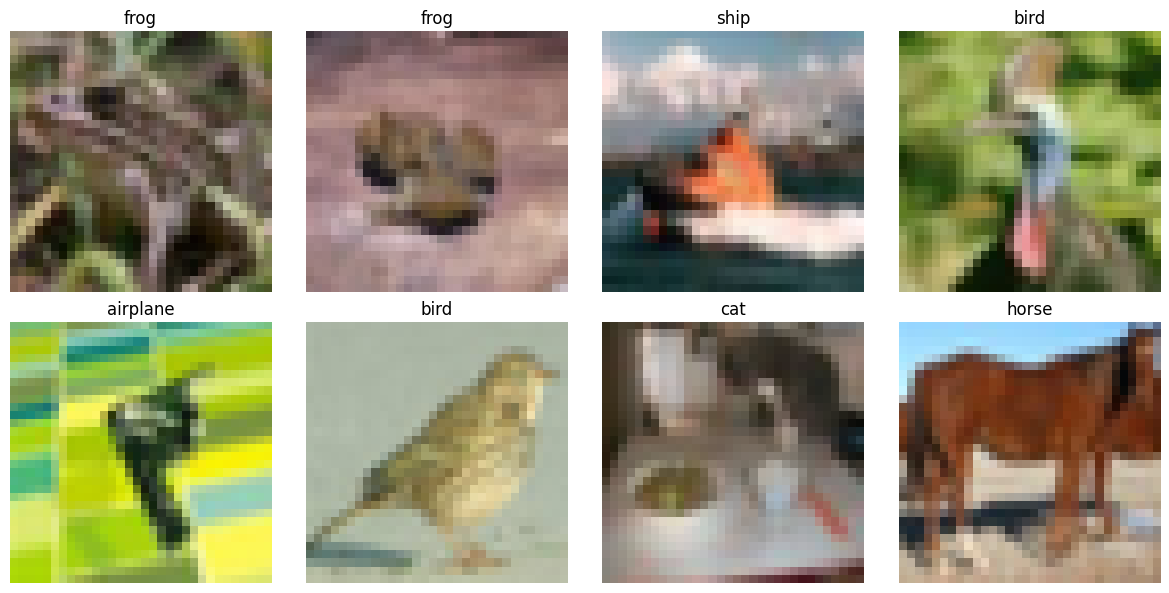


Before training:
	 Training loss 2.30373, Training accuracy 9.28%
	 Validation loss 2.30394, Validation accuracy 9.25%
	 Test loss 2.30406, Test accuracy 9.45%
-----------------------------------------------------
Epoch: 1
	 Training loss 2.28914, Training accuracy 14.88%
	 Validation loss 2.25910, Validation accuracy 20.68%
-----------------------------------------------------
Epoch: 2
	 Training loss 2.11241, Training accuracy 25.12%
	 Validation loss 1.98089, Validation accuracy 28.28%
-----------------------------------------------------
Epoch: 3
	 Training loss 1.90109, Training accuracy 31.22%
	 Validation loss 1.88425, Validation accuracy 32.41%
-----------------------------------------------------
Epoch: 4
	 Training loss 1.79270, Training accuracy 35.12%
	 Validation loss 1.74863, Validation accuracy 36.33%
-----------------------------------------------------
Epoch: 5
	 Training loss 1.69427, Training accuracy 38.33%
	 Validation loss 1.66512, Validation accuracy 39.38%
----

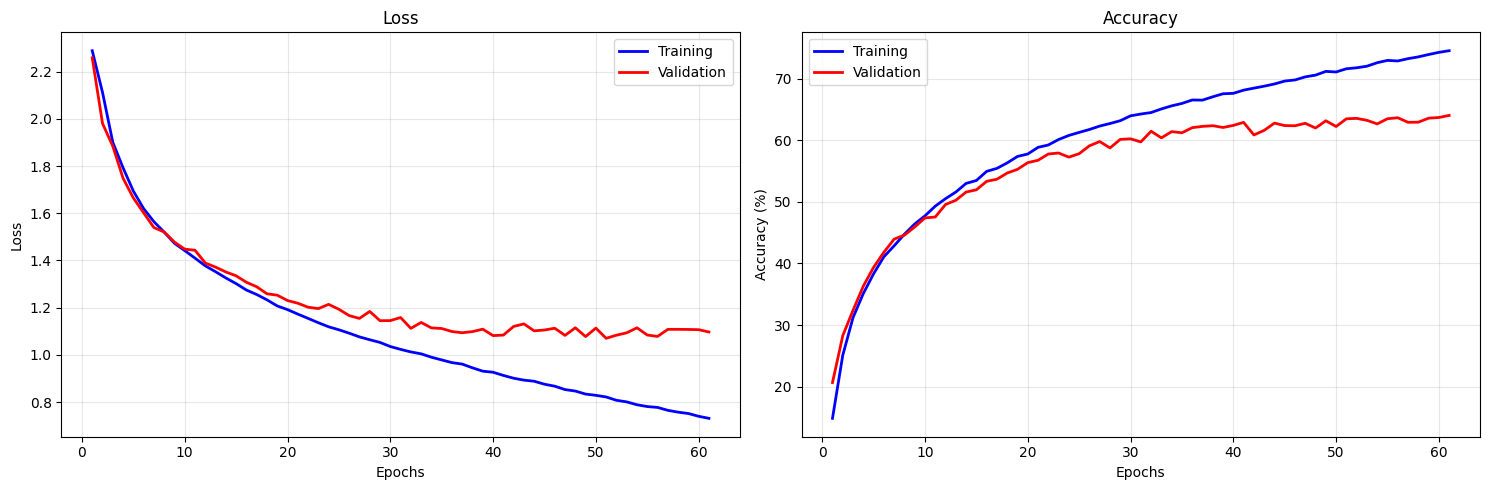

Final Training Accuracy: 74.52%
Final Validation Accuracy: 64.02%
Gap: 10.50%

CIFAR-10 Confusion Matrix:


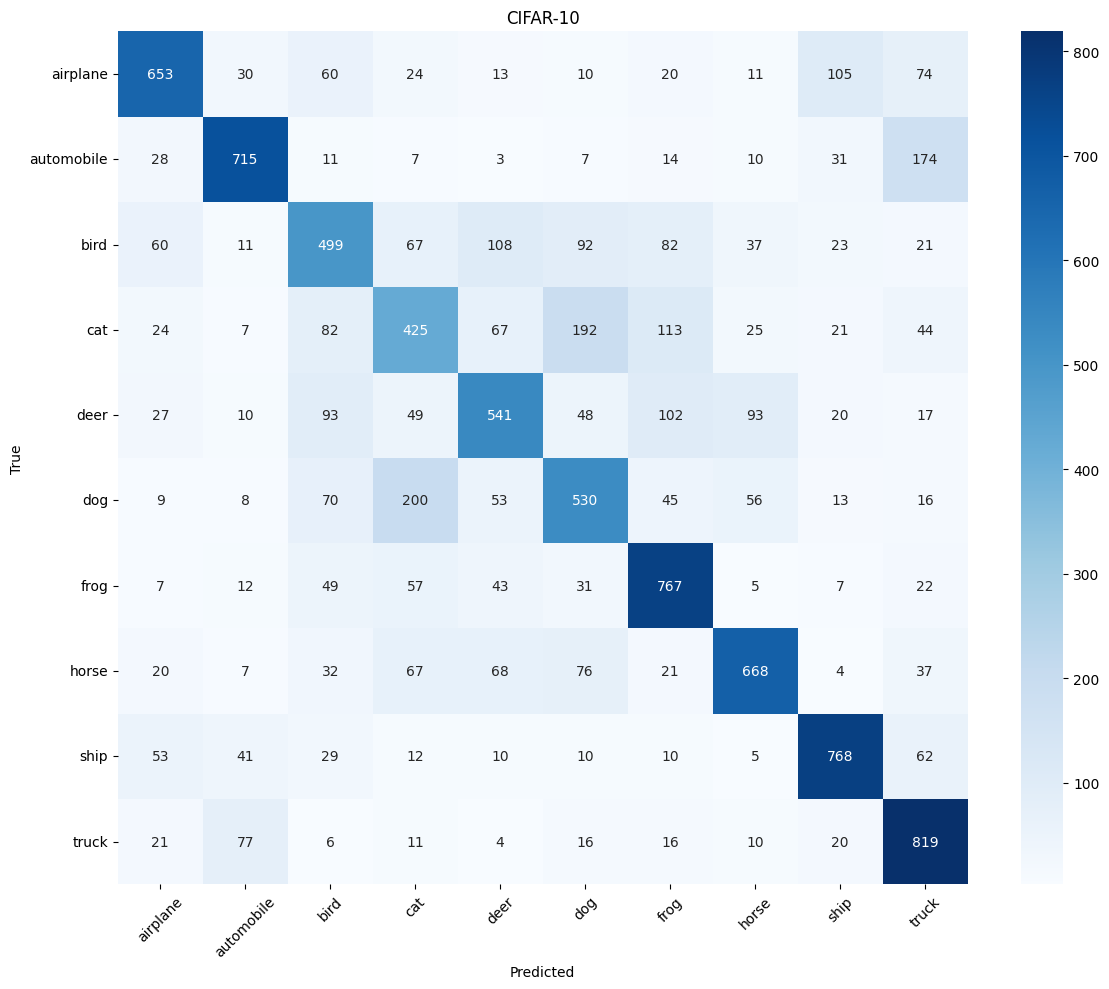

In [26]:
net, test_loader, device, train_losses, val_losses, train_accuracies, val_accuracies = main_cifar10(
    epochs=100,
    early_stopping_patience=10,
    learning_rate=0.001
)

Les performances sont ici bien moins satisfaisantes, mais comme on l'a dit plus haut on s'y attendait à cause de la plus grande compléxité des images.

<h2 style="color:#FF8C00; font-family:Arial, sans-serif;">
  Data augmentation et dropout
</h2>

In [27]:
def get_data_cifar10_augmented(batch_size):
    # Data augmentation pour le training set
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5), # Flip horizontal aléatoire
        transforms.RandomCrop(32, padding=4), # Crop aléatoire avec padding
        transforms.RandomRotation(degrees=10), # Rotation aléatoire
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Changements de couleur
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    # Pas d'augmentation pour validation/test
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    train_set = datasets.CIFAR10('./data', train=True, download=True, transform=transform_train)
    test_set = datasets.CIFAR10('./data', train=False, download=True, transform=transform_test)

    train_size = int(0.8 * len(train_set))
    val_size = len(train_set) - train_size
    train_subset, val_subset = torch.utils.data.random_split(train_set, [train_size, val_size])

    val_subset.dataset = datasets.CIFAR10('./data', train=True, download=False, transform=transform_test)
    val_indices = val_subset.indices
    val_subset = torch.utils.data.Subset(val_subset.dataset, val_indices)

    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [28]:
class LeNet_CIFAR10_Improved(torch.nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(LeNet_CIFAR10_Improved, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)

        self.fc1 = nn.Linear(16*5*5, 120)
        self.dropout1 = nn.Dropout(dropout_rate)  # Dropout après fc1
        
        self.fc2 = nn.Linear(120, 84)
        self.dropout2 = nn.Dropout(dropout_rate)  # Dropout après fc2
        
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # 32x32 -> 28x28
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # 28x28 -> 14x14
        x = F.relu(self.conv2(x))  # 14x14 -> 10x10
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # 10x10 -> 5x5
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x) 
        return x

In [29]:
def train_epoch(net, data_loader, optimizer, cost_function, device):
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = cost_function(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    avg_loss = running_loss / len(data_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def test_epoch(net, data_loader, cost_function, device):
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = cost_function(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    avg_loss = running_loss / len(data_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

In [30]:
def plot_comparison(results_orig, results_imp):
    """Plot la compaison des résultats entre l'original et l'amélioré."""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    epochs_orig = range(1, len(results_orig['train_losses']) + 1)
    epochs_imp = range(1, len(results_imp['train_losses']) + 1)
    
    # Training Loss
    ax1.plot(epochs_orig, results_orig['train_losses'], 'b-', label='Original LeNet', linewidth=2)
    ax1.plot(epochs_imp, results_imp['train_losses'], 'r-', label='Improved LeNet', linewidth=2)
    ax1.set_title('Training Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Validation Loss
    ax2.plot(epochs_orig, results_orig['val_losses'], 'b-', label='Original LeNet', linewidth=2)
    ax2.plot(epochs_imp, results_imp['val_losses'], 'r-', label='Improved LeNet', linewidth=2)
    ax2.set_title('Validation Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Training Accuracy
    ax3.plot(epochs_orig, results_orig['train_accuracies'], 'b-', label='Original LeNet', linewidth=2)
    ax3.plot(epochs_imp, results_imp['train_accuracies'], 'r-', label='Improved LeNet', linewidth=2)
    ax3.set_title('Training Accuracy')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Validation Accuracy
    ax4.plot(epochs_orig, results_orig['val_accuracies'], 'b-', label='Original LeNet', linewidth=2)
    ax4.plot(epochs_imp, results_imp['val_accuracies'], 'r-', label='Improved LeNet', linewidth=2)
    ax4.set_title('Validation Accuracy')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [31]:
def train_model(net, train_loader, val_loader, test_loader, optimizer, device, 
                epochs, patience, model_name):
    
    cost_function = nn.CrossEntropyLoss()
    early_stopping = EarlyStopping(patience=patience, restore_best_weights=True)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    print(f'\nTraining {model_name}...')
    
    for e in range(epochs):
        net.train()
        train_loss, train_acc = train_epoch(net, train_loader, optimizer, cost_function, device)
        
        net.eval()
        val_loss, val_acc = test_epoch(net, val_loader, cost_function, device)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        if (e + 1) % 10 == 0:
            print(f'Epoch {e+1:2d}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        if early_stopping(val_loss, net):
            print(f'Early stopping at epoch {e+1}!')
            break
    
    net.eval()
    test_loss, test_acc = test_epoch(net, test_loader, cost_function, device)
    
    print(f'\n{model_name} Final Results:')
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')
    
    return {
        'model': net,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'final_test_acc': test_acc,
        'test_loader': test_loader
    }

In [32]:
def compare_models():
    # compare les deux modèles LeNet sur CIFAR-10
    device = 'cuda:0' if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else 'cpu'
    print(f'Using device: {device}\n')
    
    batch_size = 128
    learning_rate = 0.001
    weight_decay = 0.0001
    momentum = 0.9
    epochs = 100
    early_stopping_patience = 5
    
    # MODEL 1: Original LeNet
    print("="*60)
    print("TRAINING ORIGINAL LENET (No augmentation, No dropout)")
    print("="*60)
    
    train_loader_orig, val_loader_orig, test_loader_orig = get_data_cifar10(batch_size)
    
    net_original = LeNet_CIFAR10().to(device)
    optimizer_orig = torch.optim.SGD(net_original.parameters(), lr=learning_rate, 
                              weight_decay=weight_decay, momentum=momentum)
    
    results_orig = train_model(net_original, train_loader_orig, val_loader_orig, 
                              test_loader_orig, optimizer_orig, device, epochs, 
                              early_stopping_patience, "Original LeNet")
    
    # MODEL 2: Improved LeNet
    print("\n" + "="*60)
    print("TRAINING IMPROVED LENET (With augmentation + dropout)")
    print("="*60)
    
    train_loader_aug, val_loader_aug, test_loader_aug = get_data_cifar10_augmented(batch_size)
    
    net_improved = LeNet_CIFAR10_Improved(dropout_rate=0.5).to(device)
    optimizer_imp = torch.optim.SGD(net_improved.parameters(), lr=learning_rate, 
                             weight_decay=weight_decay, momentum=momentum)
    
    results_imp = train_model(net_improved, train_loader_aug, val_loader_aug, 
                             test_loader_aug, optimizer_imp, device, epochs, 
                             early_stopping_patience, "Improved LeNet")
    
    print("\n" + "="*60)
    print("FINAL COMPARISON")
    print("="*60)
    
    print(f"Original LeNet Final Test Accuracy: {results_orig['final_test_acc']:.2f}%")
    print(f"Improved LeNet Final Test Accuracy: {results_imp['final_test_acc']:.2f}%")
    print(f"Improvement: {results_imp['final_test_acc'] - results_orig['final_test_acc']:.2f}%")
    
    # Plot comparison
    plot_comparison(results_orig, results_imp)
    
    return results_orig, results_imp

In [33]:
def show_augmentation_examples():
    transform_orig = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    transform_aug = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    dataset_orig = datasets.CIFAR10('./data', train=True, download=False, transform=transform_orig)
    dataset_aug = datasets.CIFAR10('./data', train=True, download=False, transform=transform_aug)
    
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']
    
    def denormalize(tensor):
        mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
        std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
        return tensor * std + mean
    
    idx = 100
    orig_img, label = dataset_orig[idx]
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    img_display = denormalize(orig_img)
    img_display = torch.clamp(img_display, 0, 1).permute(1, 2, 0)
    axes[0, 0].imshow(img_display)
    axes[0, 0].set_title(f'Original: {classes[label]}')
    axes[0, 0].axis('off')
    
    for i in range(7):
        aug_img, _ = dataset_aug[idx]
        img_display = denormalize(aug_img)
        img_display = torch.clamp(img_display, 0, 1).permute(1, 2, 0)
        
        row = (i + 1) // 4
        col = (i + 1) % 4
        axes[row, col].imshow(img_display)
        axes[row, col].set_title(f'Augmented {i+1}')
        axes[row, col].axis('off')
    
    plt.suptitle('Data Augmentation Examples', fontsize=16)
    plt.tight_layout()
    plt.show()

Data Augmentation Examples:


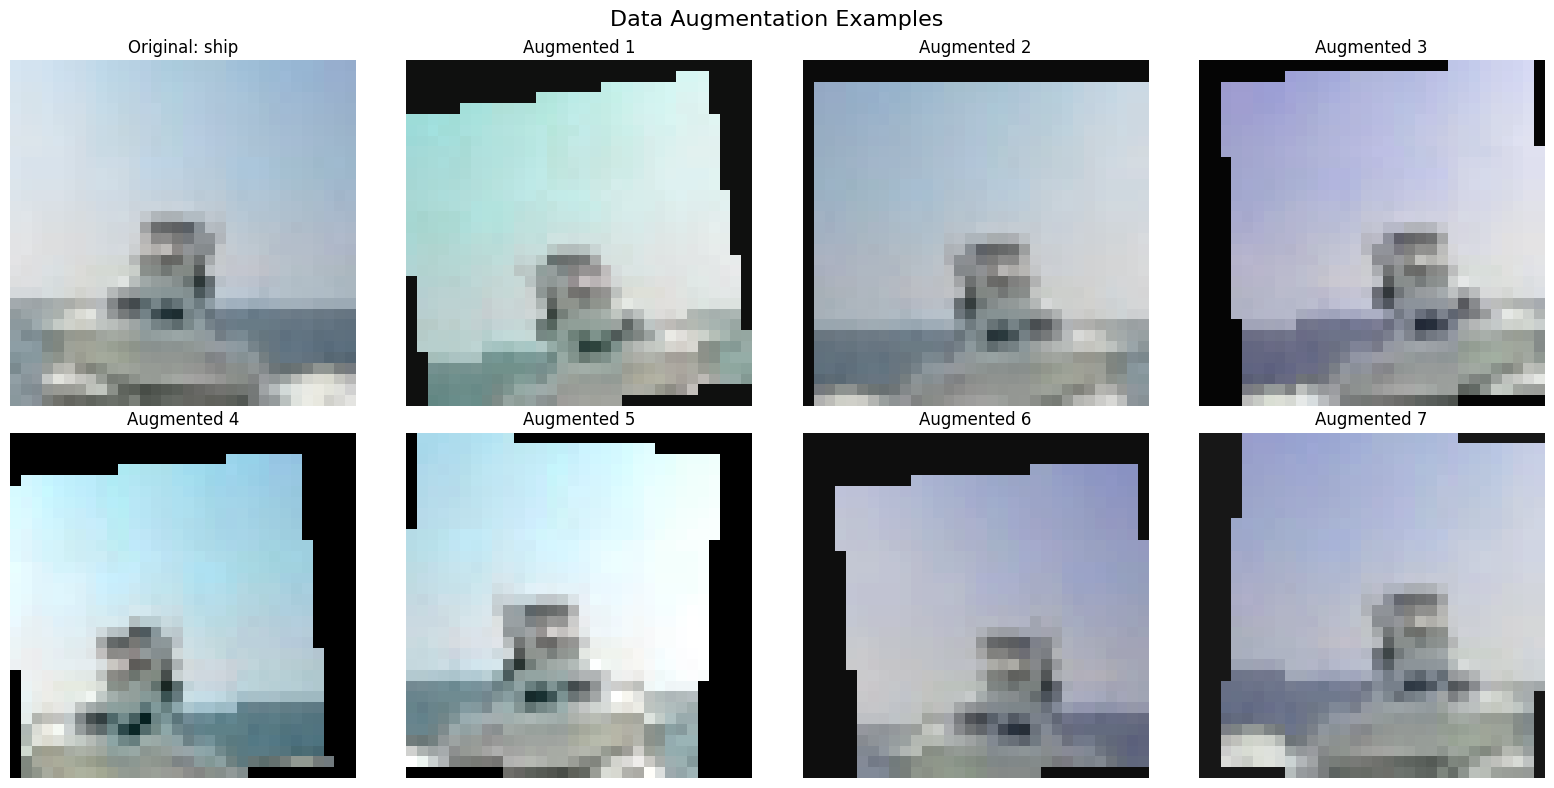

Using device: mps

TRAINING ORIGINAL LENET (No augmentation, No dropout)

Training Original LeNet...
Epoch 10: Train Loss: 1.4247, Train Acc: 48.68%, Val Loss: 1.4362, Val Acc: 47.91%
Epoch 20: Train Loss: 1.2134, Train Acc: 56.74%, Val Loss: 1.2733, Val Acc: 54.64%
Epoch 30: Train Loss: 1.0696, Train Acc: 62.29%, Val Loss: 1.1981, Val Acc: 57.85%
Epoch 40: Train Loss: 0.9561, Train Acc: 66.27%, Val Loss: 1.1461, Val Acc: 60.27%
Epoch 50: Train Loss: 0.8560, Train Acc: 69.93%, Val Loss: 1.1584, Val Acc: 60.44%
Early stopping. On restore les meilleurs poids de l'epoch 5
Early stopping at epoch 53!

Original LeNet Final Results:
Test Loss: 1.1768, Test Accuracy: 60.30%

TRAINING IMPROVED LENET (With augmentation + dropout)

Training Improved LeNet...
Epoch 10: Train Loss: 1.9036, Train Acc: 28.23%, Val Loss: 1.7576, Val Acc: 35.35%
Epoch 20: Train Loss: 1.7438, Train Acc: 35.27%, Val Loss: 1.5442, Val Acc: 43.91%
Epoch 30: Train Loss: 1.6643, Train Acc: 38.88%, Val Loss: 1.4465, Val Acc:

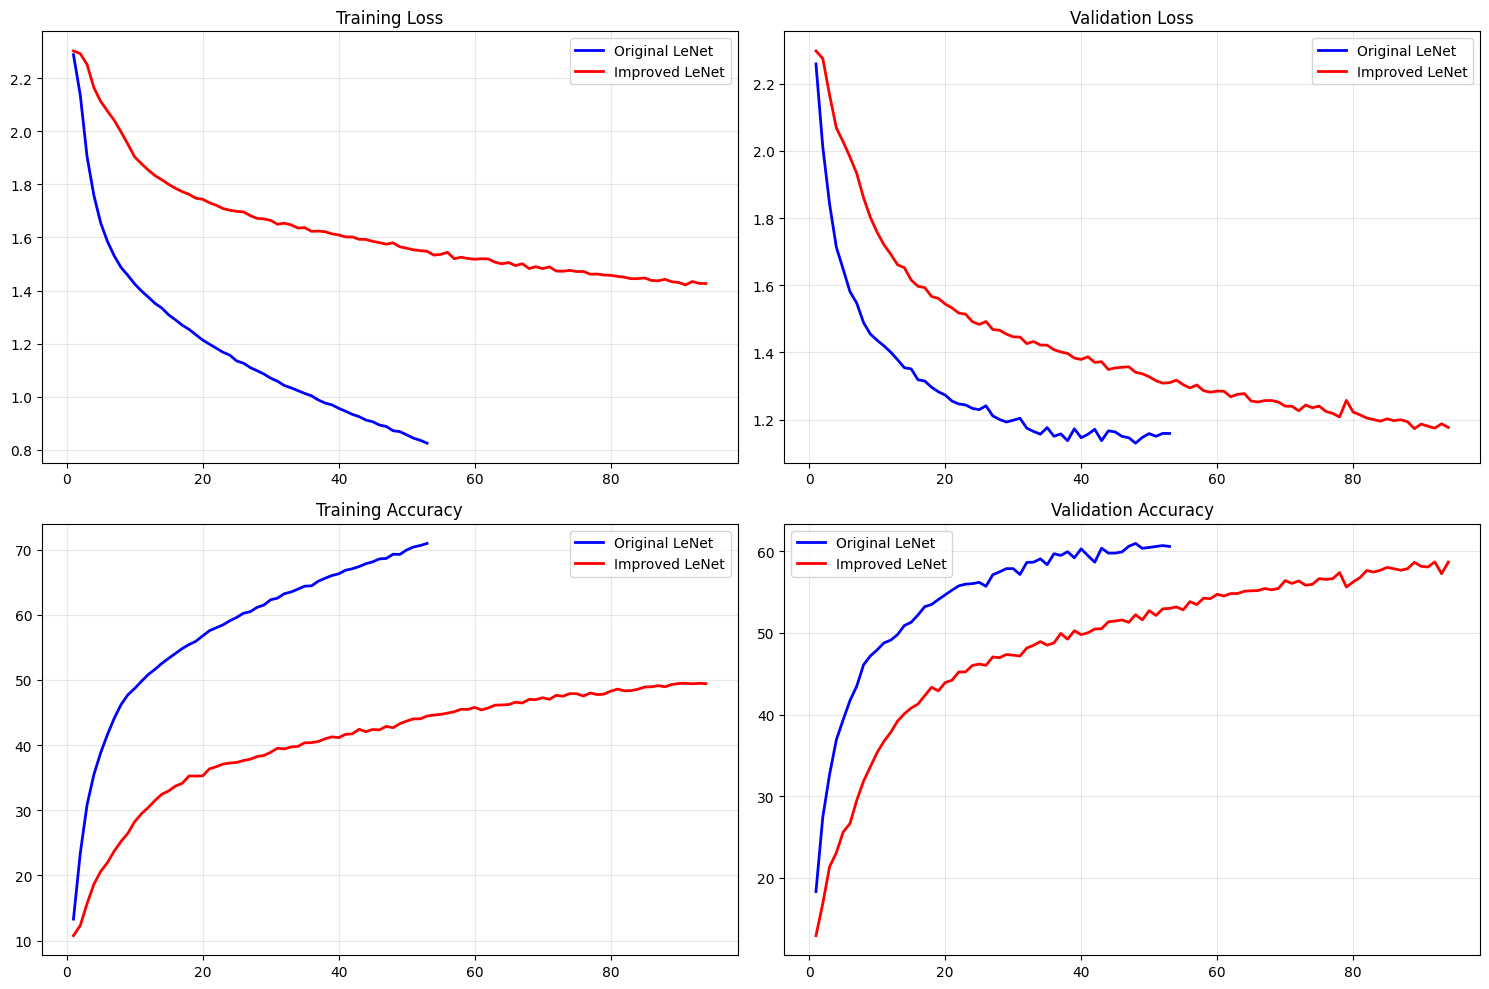


Original LeNet:


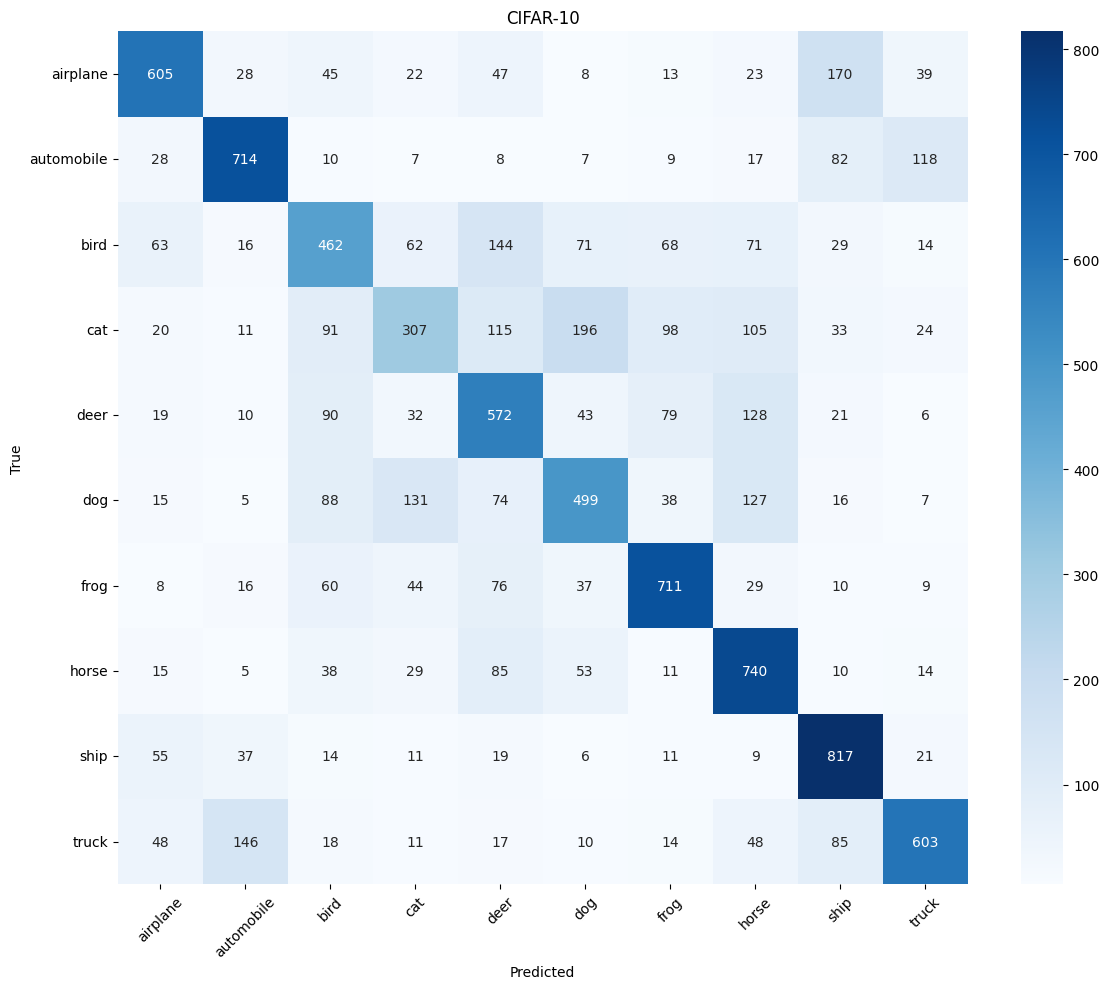


Improved LeNet:


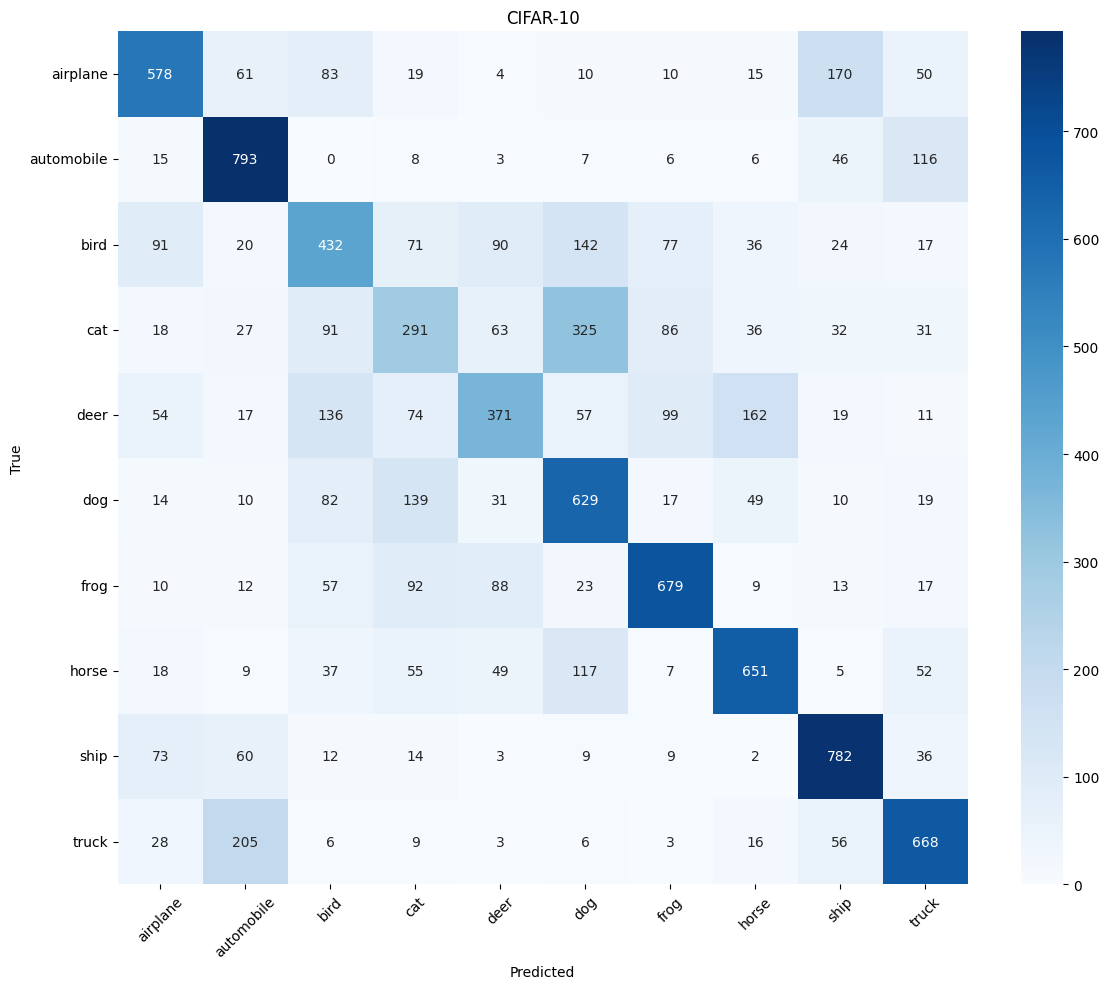

array([[578,  61,  83,  19,   4,  10,  10,  15, 170,  50],
       [ 15, 793,   0,   8,   3,   7,   6,   6,  46, 116],
       [ 91,  20, 432,  71,  90, 142,  77,  36,  24,  17],
       [ 18,  27,  91, 291,  63, 325,  86,  36,  32,  31],
       [ 54,  17, 136,  74, 371,  57,  99, 162,  19,  11],
       [ 14,  10,  82, 139,  31, 629,  17,  49,  10,  19],
       [ 10,  12,  57,  92,  88,  23, 679,   9,  13,  17],
       [ 18,   9,  37,  55,  49, 117,   7, 651,   5,  52],
       [ 73,  60,  12,  14,   3,   9,   9,   2, 782,  36],
       [ 28, 205,   6,   9,   3,   6,   3,  16,  56, 668]])

In [34]:
print("Data Augmentation Examples:")
show_augmentation_examples()
results_original, results_improved = compare_models()
print("\nOriginal LeNet:")
plot_confusion_matrix_cifar10(results_original['model'], results_original['test_loader'], 
                              'cuda:0' if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else 'cpu')
print("\nImproved LeNet:")
plot_confusion_matrix_cifar10(results_improved['model'], results_improved['test_loader'], 
                              'cuda:0' if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else 'cpu')

<h2 style="color:#FF8C00; font-family:Arial, sans-serif;">
  Resnet 18
</h2>

In [35]:
from torchvision import models

class ResNet18_CIFAR10(nn.Module):
    def __init__(self, num_classes=10, pretrained=False):
        super(ResNet18_CIFAR10, self).__init__()
        self.resnet18 = models.resnet18(pretrained=pretrained)
        
        # Adapter pour CIFAR-10 ou les images sont en 32x32 au lieu de 224x224 (entrée habituelle de ResNet)
        self.resnet18.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.resnet18.maxpool = nn.Identity()
        self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, num_classes)
        
    def forward(self, x):
        return self.resnet18(x)

In [36]:
def plot_final_comparison(lenet_results, resnet_results, pretrained_results):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    models_data = [
        ("LeNet\nAmélioré", lenet_results, 'blue'),
        ("ResNet18\n(scratch)", resnet_results, 'red'),
        ("ResNet18\n(pretrained)", pretrained_results, 'green')
    ]
    for name, results, color in models_data:
        epochs = range(1, len(results['val_accuracies']) + 1)
        ax1.plot(epochs, results['val_accuracies'], color=color, 
                label=name.replace('\n', ' '), linewidth=2)
    ax1.set_title('Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy (%)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    names = [name.replace('\n', ' ') for name, _, _ in models_data]
    accuracies = [results['final_test_acc'] for _, results, _ in models_data]
    colors = [color for _, _, color in models_data]
    bars = ax2.bar(names, accuracies, color=colors, alpha=0.7)
    ax2.set_title('Test Accuracy Final')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_ylim(0, 100)
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

On va alors comparer LeNet ET Resnet, et le faire en chargeant une version pretrained d'un Resnet18 et une non pretrained. On fera attention à ne pas set le meme LR pour eviter l'overfitting évident.

In [37]:
def train_and_compare_models():    
    device = 'cuda:0' if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else 'cpu'
    print(f'Device: {device}\n')
    
    batch_size = 128
    learning_rate = 0.001
    epochs = 50
    patience = 10
    
    train_loader, val_loader, test_loader = get_data_cifar10_augmented(batch_size)
    
    print("="*60)
    print("COMPARAISON: LeNet Amélioré vs ResNet18")
    print("="*60)
    
    print("\n1. Training LeNet Amélioré...")
    lenet = LeNet_CIFAR10_Improved(dropout_rate=0.5).to(device)
    optimizer_lenet = torch.optim.SGD(lenet.parameters(), lr=learning_rate, 
                                     weight_decay=0.0001, momentum=0.9)
    lenet_results = train_model(lenet, train_loader, val_loader, test_loader, 
                               optimizer_lenet, device, epochs, patience, "LeNet Amélioré")
    
    print("\n2. Training ResNet18 without pretrained...")
    resnet_scratch = ResNet18_CIFAR10(pretrained=False).to(device)
    optimizer_resnet = torch.optim.SGD(resnet_scratch.parameters(), lr=learning_rate, 
                                      weight_decay=0.0001, momentum=0.9)
    resnet_results = train_model(resnet_scratch, train_loader, val_loader, test_loader, 
                                optimizer_resnet, device, epochs, patience, "ResNet18")

    print("\n3. Training ResNet18 pretrained...")
    resnet_pretrained = ResNet18_CIFAR10(pretrained=True).to(device)
    optimizer_pretrained = torch.optim.SGD(resnet_pretrained.parameters(), lr=0.0001,  # LR plus bas
                                          weight_decay=0.0001, momentum=0.9)
    pretrained_results = train_model(resnet_pretrained, train_loader, val_loader, test_loader, 
                                    optimizer_pretrained, device, 30, patience, "ResNet18 Pretrained")
    
    print("\n" + "="*60)
    print("RÉSULTATS FINAUX")
    print("="*60)
    
    results = [
        ("LeNet Amélioré", lenet_results['final_test_acc']),
        ("ResNet18 (scratch)", resnet_results['final_test_acc']),
        ("ResNet18 (pretrained)", pretrained_results['final_test_acc'])]
    
    for name, acc in results: print(f"{name:25}: {acc:.2f}%")
    
    best_model = max(results, key=lambda x: x[1])
    print(f"\Best modèle: {best_model[0]} avec {best_model[1]:.2f}%")
    plot_final_comparison(lenet_results, resnet_results, pretrained_results)
    
    return lenet_results, resnet_results, pretrained_results

Device: mps

COMPARAISON: LeNet Amélioré vs ResNet18

1. Training LeNet Amélioré...

Training LeNet Amélioré...
Epoch 10: Train Loss: 1.8833, Train Acc: 28.63%, Val Loss: 1.7414, Val Acc: 34.52%
Epoch 20: Train Loss: 1.7369, Train Acc: 35.46%, Val Loss: 1.5480, Val Acc: 42.52%
Epoch 30: Train Loss: 1.6499, Train Acc: 39.38%, Val Loss: 1.4391, Val Acc: 47.71%
Epoch 40: Train Loss: 1.5591, Train Acc: 43.21%, Val Loss: 1.3363, Val Acc: 51.56%
Epoch 50: Train Loss: 1.4952, Train Acc: 46.30%, Val Loss: 1.2575, Val Acc: 54.51%

LeNet Amélioré Final Results:
Test Loss: 1.2578, Test Accuracy: 55.76%

2. Training ResNet18 without pretrained...

Training ResNet18...


/Users/mlg/venv-ai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mlg/venv-ai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 10: Train Loss: 1.1210, Train Acc: 59.99%, Val Loss: 1.1176, Val Acc: 60.40%
Epoch 20: Train Loss: 0.8240, Train Acc: 71.08%, Val Loss: 0.7829, Val Acc: 72.75%
Epoch 30: Train Loss: 0.6582, Train Acc: 76.95%, Val Loss: 0.6643, Val Acc: 77.44%
Epoch 40: Train Loss: 0.5444, Train Acc: 80.81%, Val Loss: 0.5353, Val Acc: 81.82%
Epoch 50: Train Loss: 0.4626, Train Acc: 83.69%, Val Loss: 0.5207, Val Acc: 82.30%

ResNet18 Final Results:
Test Loss: 0.5412, Test Accuracy: 81.85%

3. Training ResNet18 pretrained...


/Users/mlg/venv-ai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/mlg/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 39.8MB/s]



Training ResNet18 Pretrained...
Epoch 10: Train Loss: 1.0801, Train Acc: 62.34%, Val Loss: 0.9548, Val Acc: 66.55%
Epoch 20: Train Loss: 0.7914, Train Acc: 72.68%, Val Loss: 0.6712, Val Acc: 76.42%
Epoch 30: Train Loss: 0.6471, Train Acc: 77.44%, Val Loss: 0.5442, Val Acc: 81.15%

ResNet18 Pretrained Final Results:
Test Loss: 0.5523, Test Accuracy: 80.93%

RÉSULTATS FINAUX
LeNet Amélioré           : 55.76%
ResNet18 (scratch)       : 81.85%
ResNet18 (pretrained)    : 80.93%
\Best modèle: ResNet18 (scratch) avec 81.85%


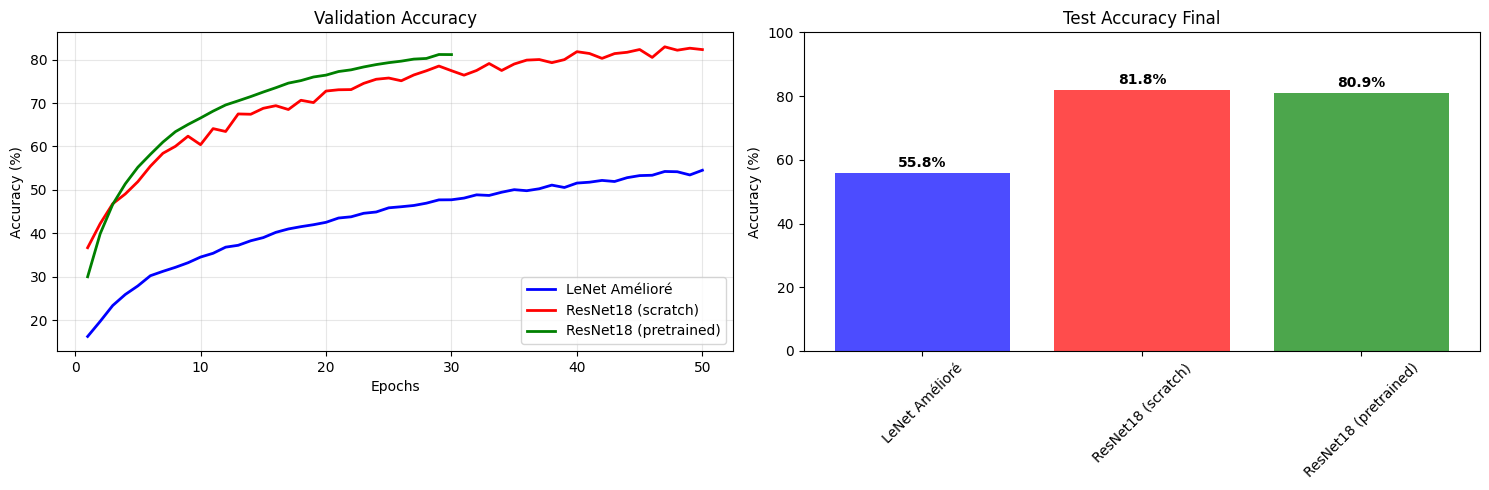


Matrice de confusion du meilleur modèle:


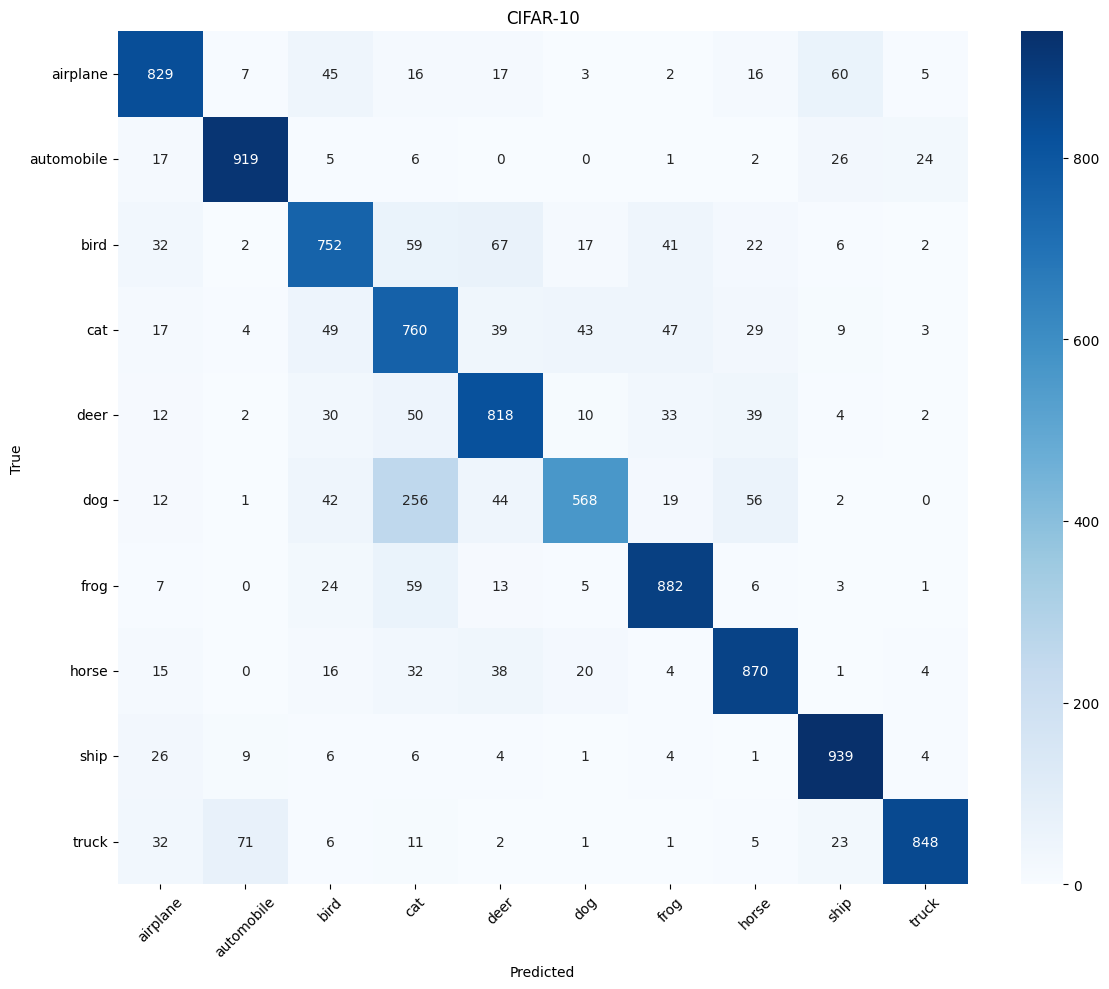

array([[829,   7,  45,  16,  17,   3,   2,  16,  60,   5],
       [ 17, 919,   5,   6,   0,   0,   1,   2,  26,  24],
       [ 32,   2, 752,  59,  67,  17,  41,  22,   6,   2],
       [ 17,   4,  49, 760,  39,  43,  47,  29,   9,   3],
       [ 12,   2,  30,  50, 818,  10,  33,  39,   4,   2],
       [ 12,   1,  42, 256,  44, 568,  19,  56,   2,   0],
       [  7,   0,  24,  59,  13,   5, 882,   6,   3,   1],
       [ 15,   0,  16,  32,  38,  20,   4, 870,   1,   4],
       [ 26,   9,   6,   6,   4,   1,   4,   1, 939,   4],
       [ 32,  71,   6,  11,   2,   1,   1,   5,  23, 848]])

In [38]:
lenet_results, resnet_results, pretrained_results = train_and_compare_models()
best_results = max([lenet_results, resnet_results, pretrained_results],key=lambda x: x['final_test_acc'])
print(f"\nMatrice de confusion du meilleur modèle:")
device = 'cuda:0' if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else 'cpu'
plot_confusion_matrix_cifar10(best_results['model'], best_results['test_loader'], device)